# Mask Detection

### Imports

In [40]:
import pathlib
import shutil
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os, random
import tensorflow as tf
# plot_model requires graphviz & pydot
from tensorflow.keras.utils import plot_model
import json
print(tf.__version__)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging


2.15.0


### Getting the Data

In [2]:
data_dir_path = "data/"
shutil.unpack_archive(data_dir_path + "/archive.zip", data_dir_path)

data_dir = pathlib.Path(data_dir_path + "/obj/").with_suffix('')

image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


data/obj/masked (1915).jpg


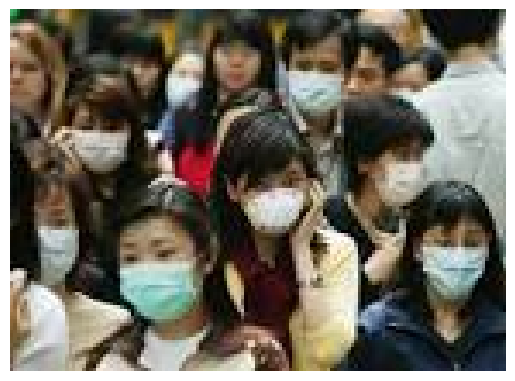

In [16]:
sample_img_path = str(image_files[101])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [17]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.5243055555555556 0.5095238095238095 0.14583333333333334 0.23809523809523808\n', '0 0.6145833333333334 0.19047619047619047 0.13194444444444445 0.24761904761904763\n', '0 0.3020833333333333 0.7523809523809524 0.1875 0.3047619047619048\n', '0 0.8923611111111112 0.6952380952380952 0.1597222222222222 0.26666666666666666\n', '0 0.7916666666666666 0.4142857142857143 0.125 0.23809523809523808\n', '0 0.17708333333333334 0.34285714285714286 0.14583333333333334 0.26666666666666666\n']


### Split into Training, Validation, and Test

The following function filter the files, generating 3 lists:

- training files (70% of images)
- validation files (20% of images)
- test files (last 10%)

In [18]:
def list_files(full_data_path = "data/obj/", image_ext = '.jpg', split_percentage = [70, 20]):


    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue


                strip = file[0:len(file) - len(".txt")]
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [19]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


In [23]:
with open("./data/training_files.json", 'w') as file:
    json.dump(training_files, file)
with open("./data/validation_files.json", 'w') as file:
    json.dump(validation_files, file)
with open("./data/test_files.json", 'w') as file:
    json.dump(test_files, file)

### Resize Images and Annotations

In [24]:
input_size = 244

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

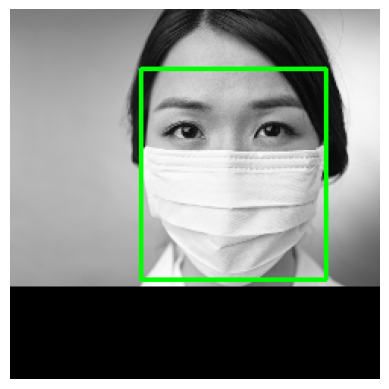

In [33]:
temp_img = cv.imread("data/obj/masked (1476).jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.6083333333333333, 0.5966666666666667, 0.5066666666666667, 0.7666666666666667]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

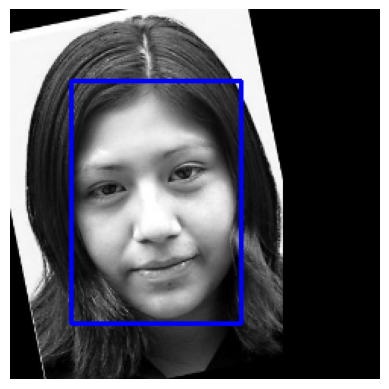

In [38]:
temp_img = cv.imread("data/obj/unmasked (1764).jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5359375, 0.5277136258660509, 0.628125, 0.6628175519630485]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

### Create TensorFlow Dataset

In [41]:
def data_load(files, full_data_path = "data/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [42]:
raw_train_ds = data_load(training_files)

2023-12-16 00:38:53.965638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 00:38:53.981457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [43]:
raw_validation_ds = data_load(validation_files)

In [44]:
raw_test_ds = data_load(test_files)

In [45]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [46]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [47]:
train_ds = tune_training_ds(raw_train_ds)

In [48]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [49]:
validation_ds = tune_validation_ds(raw_validation_ds)

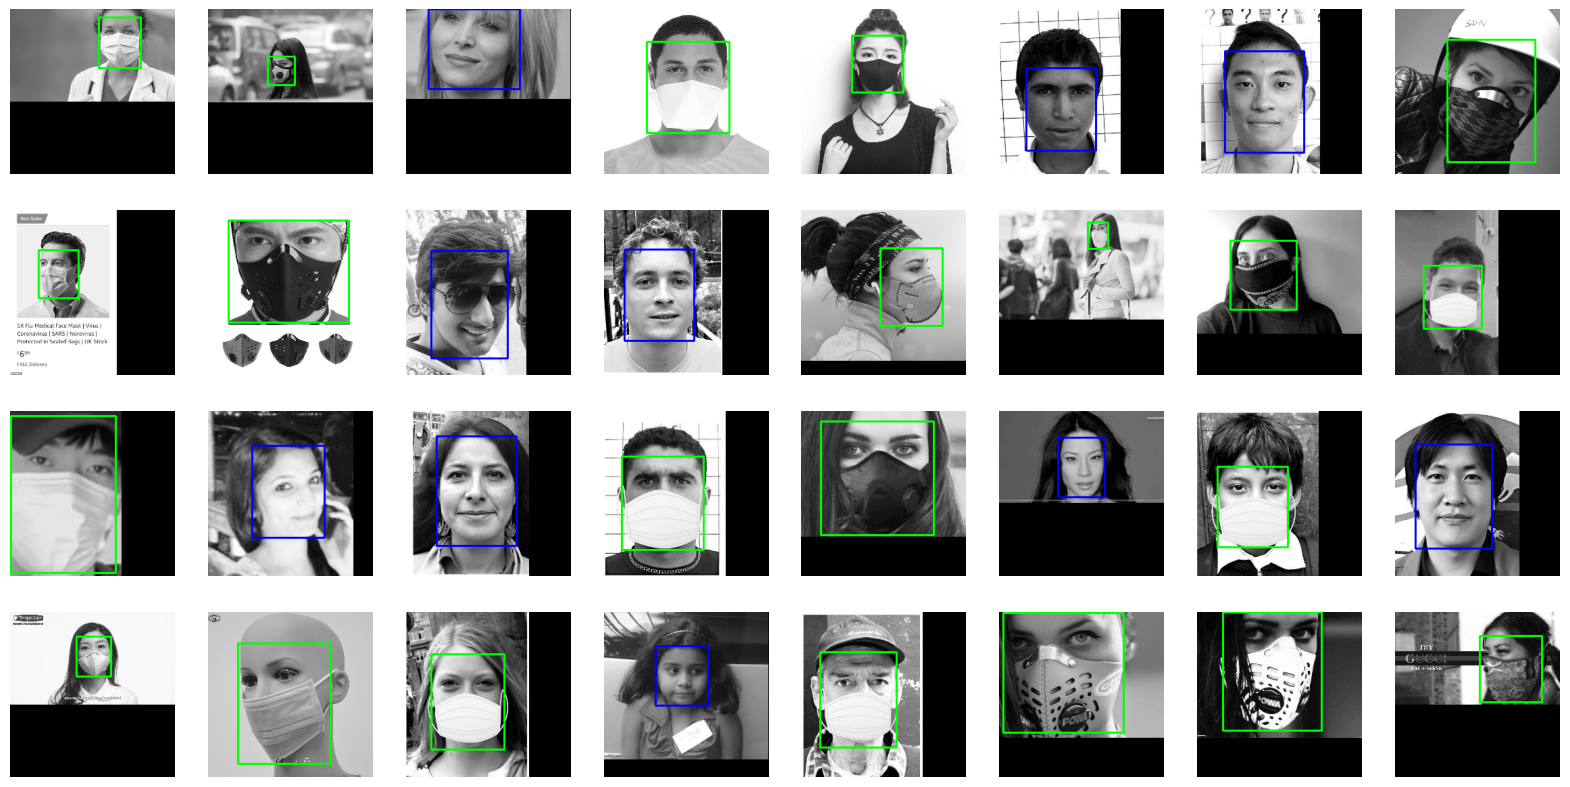

In [50]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

### Create Model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Functional API, as follows:

In [52]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adapter(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adapter(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [53]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 242, 242, 16)         160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 121, 121, 16)         0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 119, 119, 32)         4640      ['average_pooling2d[0][0]'

                                                                                                  
 average_pooling2d_1 (Avera  (None, 59, 59, 32)           0         ['conv2d_1[0][0]']            
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)           (None, 57, 57, 64)           18496     ['average_pooling2d_1[0][0]'] 
                                                                                                  
 dropout (Dropout)           (None, 57, 57, 64)           0         ['conv2d_2[0][0]']            
                                                                                                  
 average_pooling2d_2 (Avera  (None, 28, 28, 64)           0         ['dropout[0][0]']             
 gePooling2D)                                                                                     
          

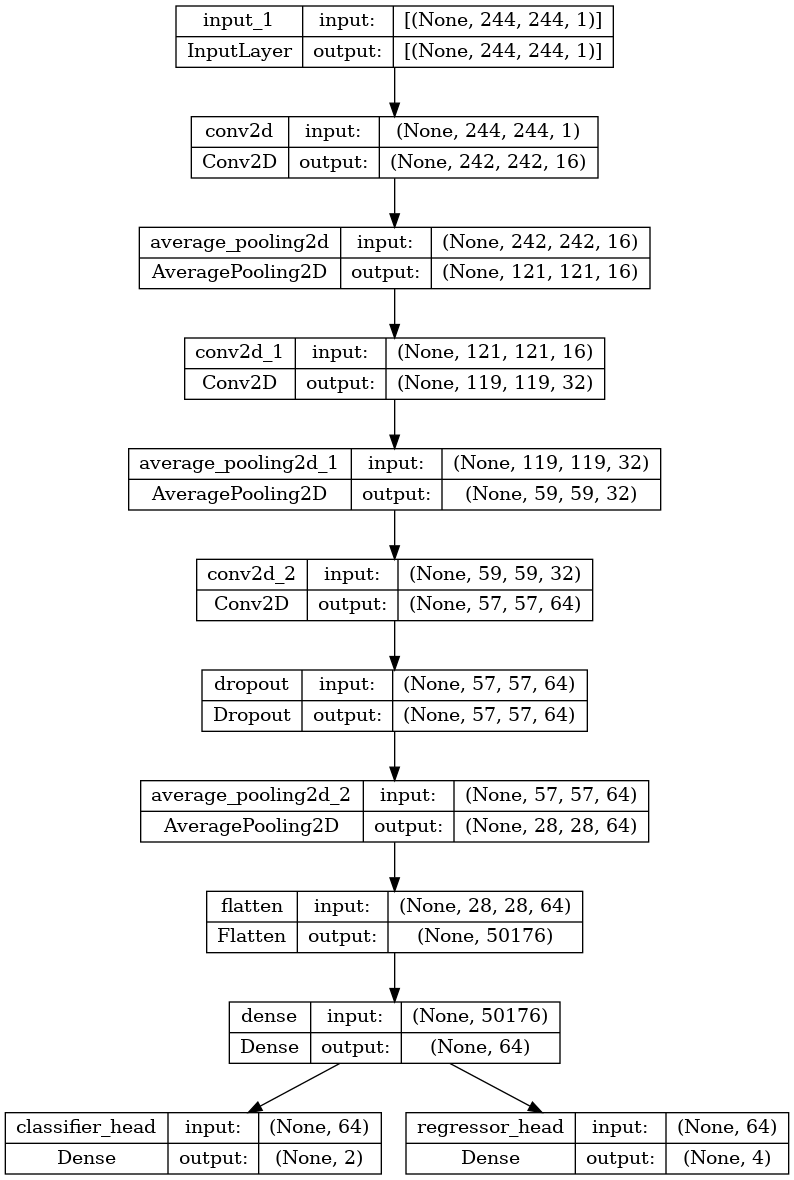

In [78]:
# https://graphviz.gitlab.io/download/
plot_model(model, show_shapes=True, show_layer_names=True)

## Model training

Our model is all set and we can start the training, as shown in the next cell:

In [59]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=0)


The training performance can be checked in the charts below.

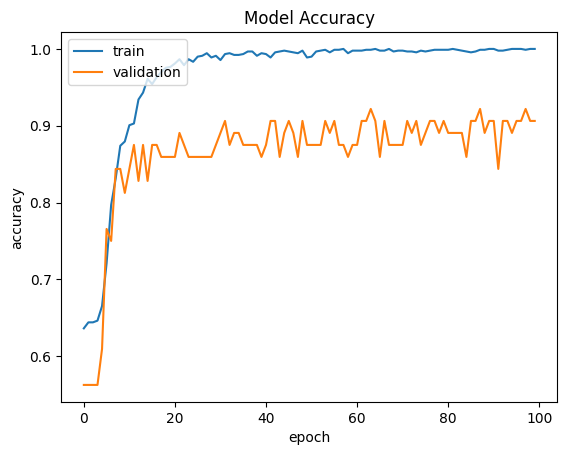

In [60]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

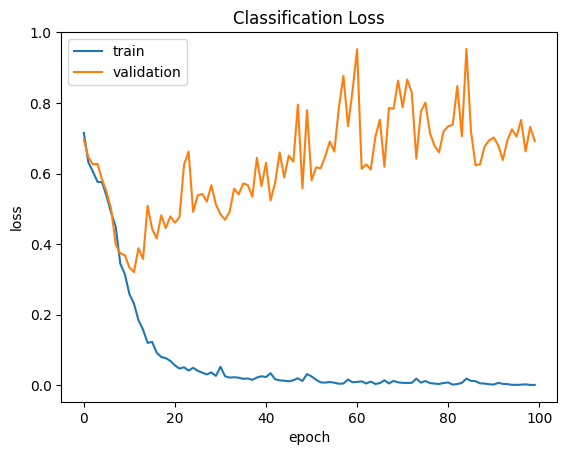

In [61]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

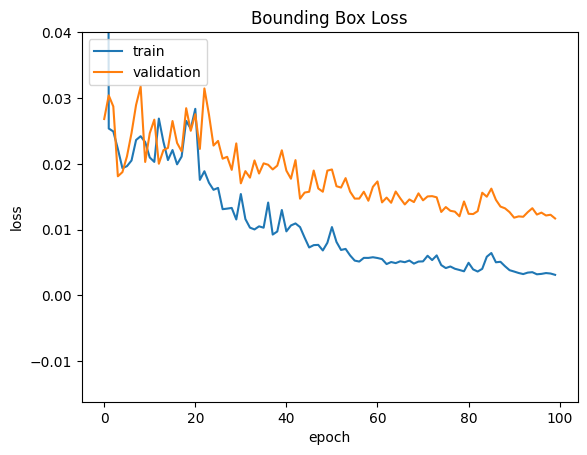

In [77]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylim(top=0.04)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation

In [63]:
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [64]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

The model performance is evaluated on the test dataset. Green boxes indicate correct classification in which the predicted label (masked-unmasked) matches with the actual label.
A red box indicates a wrong classification.

20


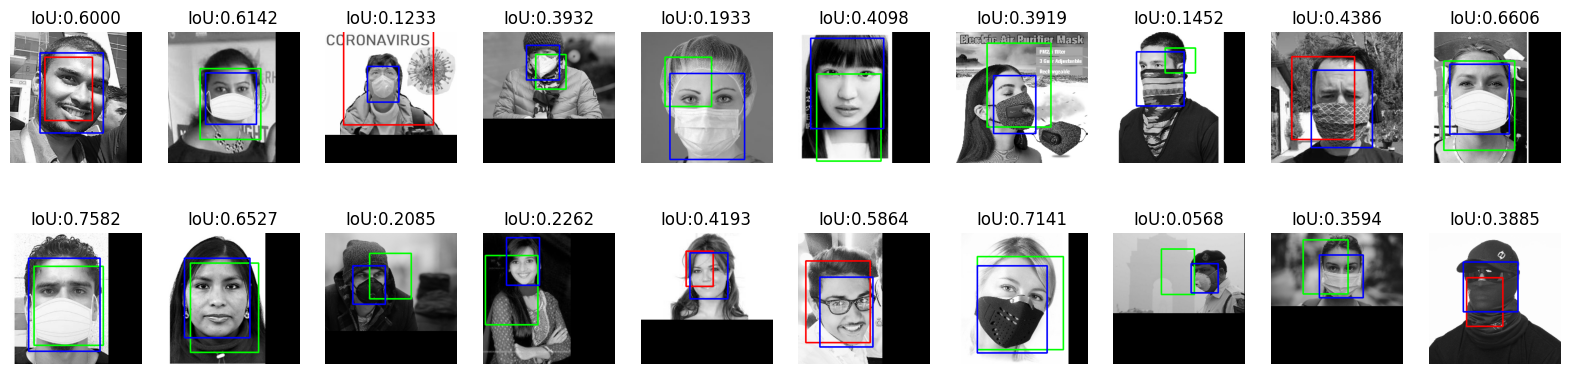

In [65]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## Conclusion

Taking in consideration the small size of the data used for training and the fact of training the model from scratch without transfer learning, the results above are surprisingly good. We can think in ways to improve it even more:

- The first option to improve the bound box and classificataion performance is increase the training data size which can be easily achieved by data augmentation.

- Tweaking the hyperparameters and finding on way to improve the regularization can either improve the results, reducing the classification and regression errors.

A good enhacement here would be calculating mAP comparing the results to one or more object detectors. Implementing other features like multiscale and multiple detections can also provide a solid understand of real challengings in developing an battle-tested object detector.